In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from tqdm import tqdm
from datetime import datetime, timedelta

from config import PLOTS_DIR, DELAY_DIST, REAL_DATA_PRIOR_K_GEOMETRIC_P, REAL_DATA_PRIOR_THETA_SIGMA
import config
config.K_MAX = 15

from methods import run_rjmcmc, run_pelt, run_binseg, get_rtacfr_signal
from evaluation_realdata import (
    calculate_bic, 
    calculate_out_of_sample_rmse, 
    load_event_list, 
    calculate_hausdorff_alignment,
    calculate_event_hit_probability,
    calculate_alignment_metrics
)

# Set publication-quality plotting style
sns.set_theme(context='talk', style='whitegrid')
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'legend.fontsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.linewidth': 2.5,  # Increase border width
    'axes.edgecolor': 'black',  # Set border color to black
    'lines.linewidth': 2.5,
    'figure.figsize': (16, 10),
    'figure.dpi': 300,
    'savefig.dpi': 400,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1
})

## 1. Load and Preprocess Data

In [2]:
# Create plots directory if it doesn't exist
if not os.path.exists(PLOTS_DIR):
    os.makedirs(PLOTS_DIR)

# Load the dataset
df = pd.read_csv('JP_Data.csv')
df['date'] = pd.to_datetime(df['date'])

# Ensure data is sorted by date and get the final length
df = df.sort_values('date').reset_index(drop=True)
N = df.shape[0]

# Prepare the data dictionary required by the methods
data = {
    'cases': df['ct'].values,
    'deaths': df['dt'].values
}

print(f"Loaded data for Japan from {df['date'].min().date()} to {df['date'].max().date()} (T = {N} days).")

Loaded data for Japan from 2020-02-01 to 2021-12-31 (T = 700 days).


## 2. Visualize Epidemic Waves in Japan

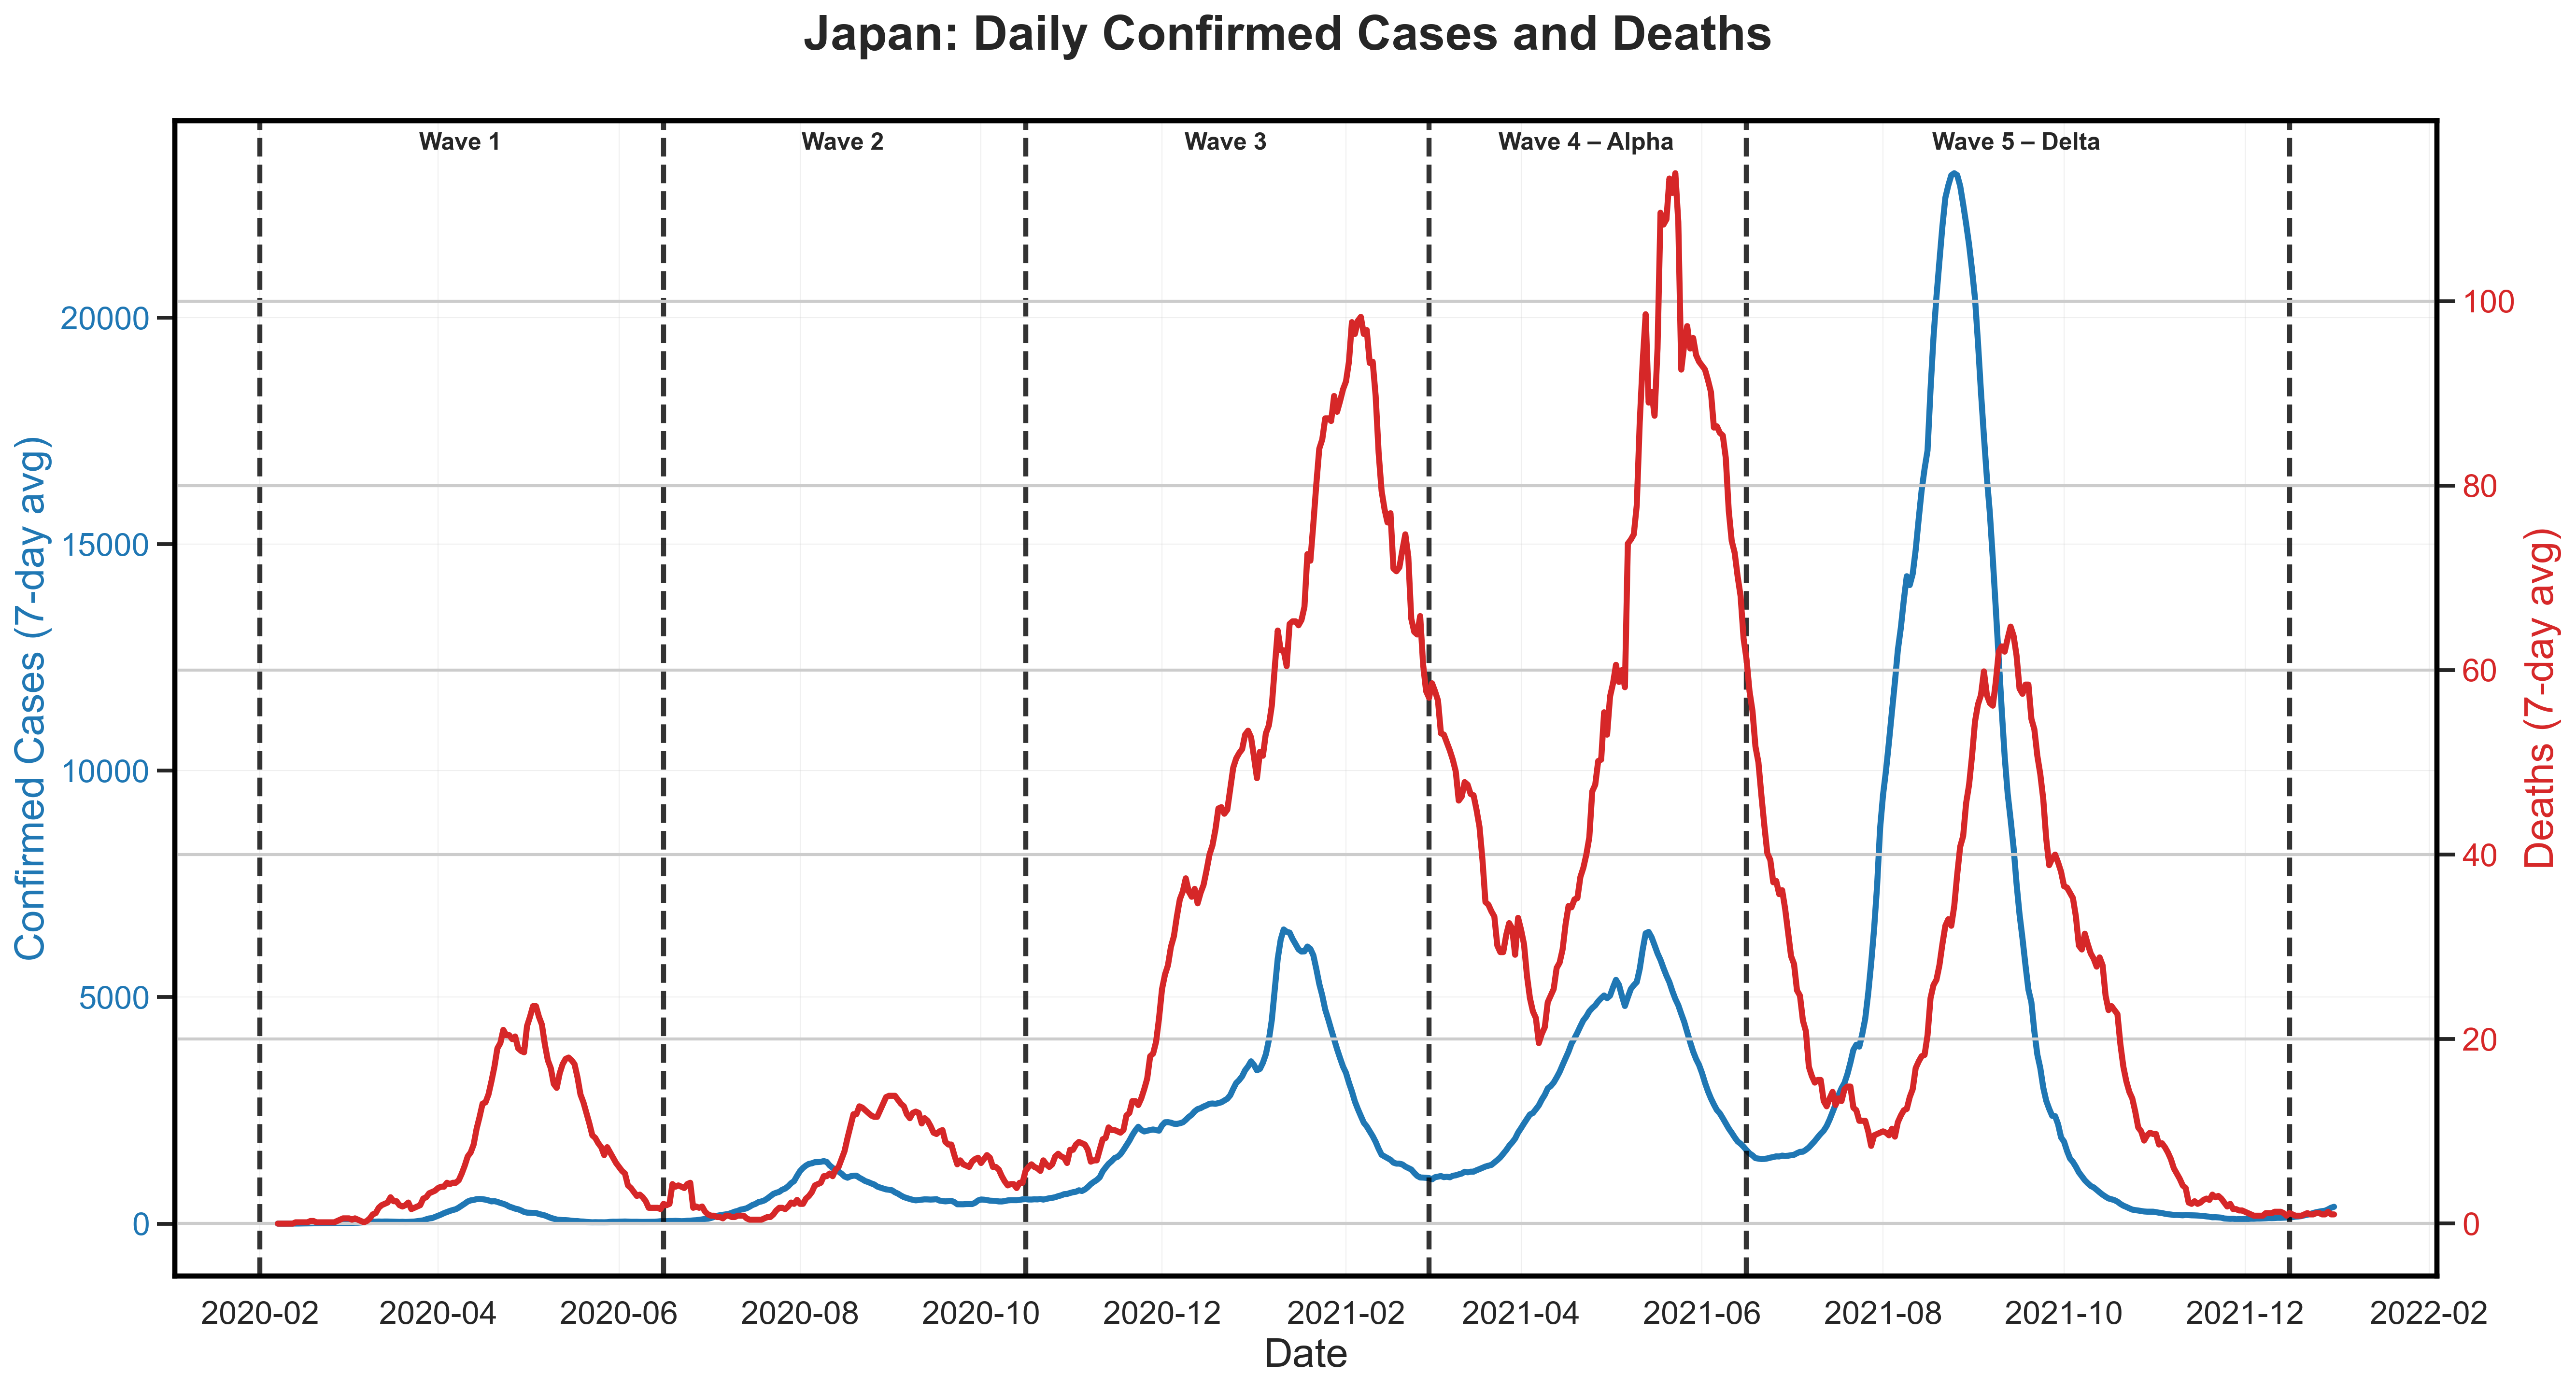

In [3]:
fig, ax1 = plt.subplots(figsize=(18, 10))

color = 'tab:blue'
ax1.set_xlabel('Date', fontsize=20)
ax1.set_ylabel('Confirmed Cases (7-day avg)', color=color, fontsize=20)
ax1.plot(df['date'], df['ct'].rolling(7).mean(), color=color, label='Confirmed Cases (7-day avg)', linewidth=3)
ax1.tick_params(axis='y', labelcolor=color, labelsize=16)
ax1.tick_params(axis='x', labelsize=16)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Deaths (7-day avg)', color=color, fontsize=20)
ax2.plot(df['date'], df['dt'].rolling(7).mean(), color=color, label='Deaths (7-day avg)', linewidth=3)
ax2.tick_params(axis='y', labelcolor=color, labelsize=16)

# Waves (variant-dominant windows)
# Source: Nature Scientific Reports (2023) – Alpha 4th, Delta 5th, Omicron 6th wave.
# Trim Wave 6 to data end if your series ends on 2021-12-31.
waves = [
    ("Wave 1", datetime(2020,2,1),  datetime(2020,6,15)),
    ("Wave 2", datetime(2020,6,16), datetime(2020,10,15)),
    ("Wave 3", datetime(2020,10,16), datetime(2021,2,28)),
    ("Wave 4 – Alpha",   datetime(2021,3,1),  datetime(2021,6,15)),
    ("Wave 5 – Delta",   datetime(2021,6,16), datetime(2021,12,15)),
     # ("Wave 6 – Omicron", datetime(2021,12,16), datetime(2021,12,31)),  # clipped to plot end
]

# Draw shaded spans and a small centered label at the top for each wave
for i, (label, start, end) in enumerate(waves):
    ax1.axvline(start, color='black', linestyle='--', linewidth=2.5, alpha=0.8)
    mid = start + (end - start)/2
    ax1.annotate(label,
                 xy=(mid, 0.99), xycoords=('data', 'axes fraction'),
                 ha='center', va='top', fontsize=12, fontweight='bold')
ax1.axvline(datetime(2021,12,16), color='black', linestyle='--', linewidth=2.5, alpha=0.8)

# Format x-axis for dates
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Add grid for better readability
ax1.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)

# Set prominent black borders for all spines
for spine in ax1.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(2.5)
    spine.set_visible(True)
for spine in ax2.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(2.5)
    spine.set_visible(True)

# Title and layout
fig.suptitle('Japan: Daily Confirmed Cases and Deaths', fontsize=24, y=0.96, fontweight='bold')
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(os.path.join(PLOTS_DIR, 'japan_cases_and_deaths.pdf'), dpi=400, bbox_inches='tight')
plt.show()

## 3. Run All Methods on Japan Data

In [4]:
print("\nRunning RJMCMC sampler on Japan data...")
np.random.seed(123)
rjmcmc_results_full = run_rjmcmc(data, p_geom=REAL_DATA_PRIOR_K_GEOMETRIC_P, 
                                 theta_sigma=REAL_DATA_PRIOR_THETA_SIGMA, 
                                 summary_method='mode')

print("\nRunning rtaCFR signal estimator...")
rtacfr_signal = get_rtacfr_signal(data, 'JapanRealData', 0)

print("\nRunning PELT on the rtaCFR signal...")
pelt_results = run_pelt(data, 'JapanRealData', 0)

print("\nRunning Binary Segmentation on the rtaCFR signal...")
binseg_results = run_binseg(data, 'JapanRealData', 0)


Running RJMCMC sampler on Japan data...

Running rtaCFR signal estimator...

Running PELT on the rtaCFR signal...

Running Binary Segmentation on the rtaCFR signal...


In [5]:
results_dict = {
    'RJMCMC': rjmcmc_results_full,
    'PELT': pelt_results,
    'BinSeg': binseg_results
}

## 4. Quantative Evaluation

In [6]:
# --- 1. Parsimony Evaluation (BIC) ---
print("\nCalculating BIC scores...")
bic_scores = {}
for name, res in results_dict.items():
    bic_scores[name] = calculate_bic(
        data['deaths'], data['cases'], res['p_t_hat'], res['k_est'], DELAY_DIST
    )

# --- 2. Prediction Error (RMSE) ---
print("\nCalculating Out-of-Sample RMSE (this may take a while)...")
rmse_scores = {}
method_map_rmse = {'RJMCMC': run_rjmcmc, 'PELT': run_pelt, 'BinSeg': run_binseg}
for name, func in method_map_rmse.items():
    rmse_scores[name] = calculate_out_of_sample_rmse(data, func, DELAY_DIST, n_splits=3)

# --- 3. Alignment with Events ---
print("\nCalculating Alignment with Events...")
events_data = {
    'event_name': [
        # "Start Wave 1 (Original)",
        # "Start Wave 2 (European)",
        # "Start Wave 3 (Pre-Alpha)",
        # "Start Wave 4 (Alpha)",
        # "Start Wave 5 (Delta)",
        # "Start Wave 6 (Omicron)",
        "School closures requested",
        "SoE declared (Wave 1)",
        "SoE expanded nationwide",
        "SoE lifted",
        "Okinawa SoE",
        "Second SoE (Tokyo area)",
        "SoE expanded to 11 cities",
        "SoE fully lifted",
        "Vaccination begins (HCW)",
        "Moderna & AZ approved"
    ],
    'date': [
        # "2020-02-01",
        # "2020-06-16",
        # "2020-10-16",
        # "2021-03-01",
        # "2021-06-16",
        # "2021-12-16",
        "2020-02-27",
        "2020-04-07",
        "2020-04-16",
        "2020-05-25",
        "2020-08-01",
        "2021-01-07",
        "2021-01-13",
        "2021-09-28",
        "2021-02-17",
        "2021-05-21"
    ]
}
events_df_demo = pd.DataFrame(events_data)
events_df_demo.to_csv('events.csv', index=False)
events = load_event_list('events.csv', df['date'].iloc[0])

hausdorff_scores = {}

for name, res in results_dict.items():
    hausdorff_scores[name] = calculate_hausdorff_alignment(
        np.array(res['taus_est']).tolist(), events['time_idx'].tolist()
    )


Calculating BIC scores...

Calculating Out-of-Sample RMSE (this may take a while)...
Running Time Series Cross-Validation for run_rjmcmc...


100%|██████████| 3/3 [01:18<00:00, 26.32s/it]


Running Time Series Cross-Validation for run_pelt...


100%|██████████| 3/3 [00:00<00:00, 49.46it/s]


Running Time Series Cross-Validation for run_binseg...


100%|██████████| 3/3 [00:00<00:00, 50.95it/s]


Calculating Alignment with Events...


In [7]:
# --- Consolidate and Save Results ---
summary_data = {
    'BIC': pd.Series(bic_scores),
    'RMSE': pd.Series(rmse_scores),
    'HD': pd.Series(hausdorff_scores)
}

summary_df = pd.DataFrame(summary_data)

print("\n--- Quantitative Evaluation Summary ---")
print(summary_df.round(3))

csv_path = os.path.join(PLOTS_DIR, 'real_data_evaluation_summary.csv')
latex_path = os.path.join(PLOTS_DIR, 'real_data_evaluation_summary.tex')
summary_df.round(3).to_csv(csv_path)
summary_df.round(3).to_latex(latex_path, caption='Quantitative Evaluation Summary for Japan Data.', label='tab:jp_results', float_format="%.3f")
print(f"\nEvaluation summary saved to {csv_path} and {latex_path}")


--- Quantitative Evaluation Summary ---
             BIC    RMSE     HD
RJMCMC  4909.711  27.122  110.0
PELT    5252.963  58.134  109.0
BinSeg  5250.049  30.866  109.0

Evaluation summary saved to plots\real_data_evaluation_summary.csv and plots\real_data_evaluation_summary.tex


## 5. Compare and Visualize CFR Estimates

In [8]:
rjmcmc_results = results_dict["RJMCMC"]

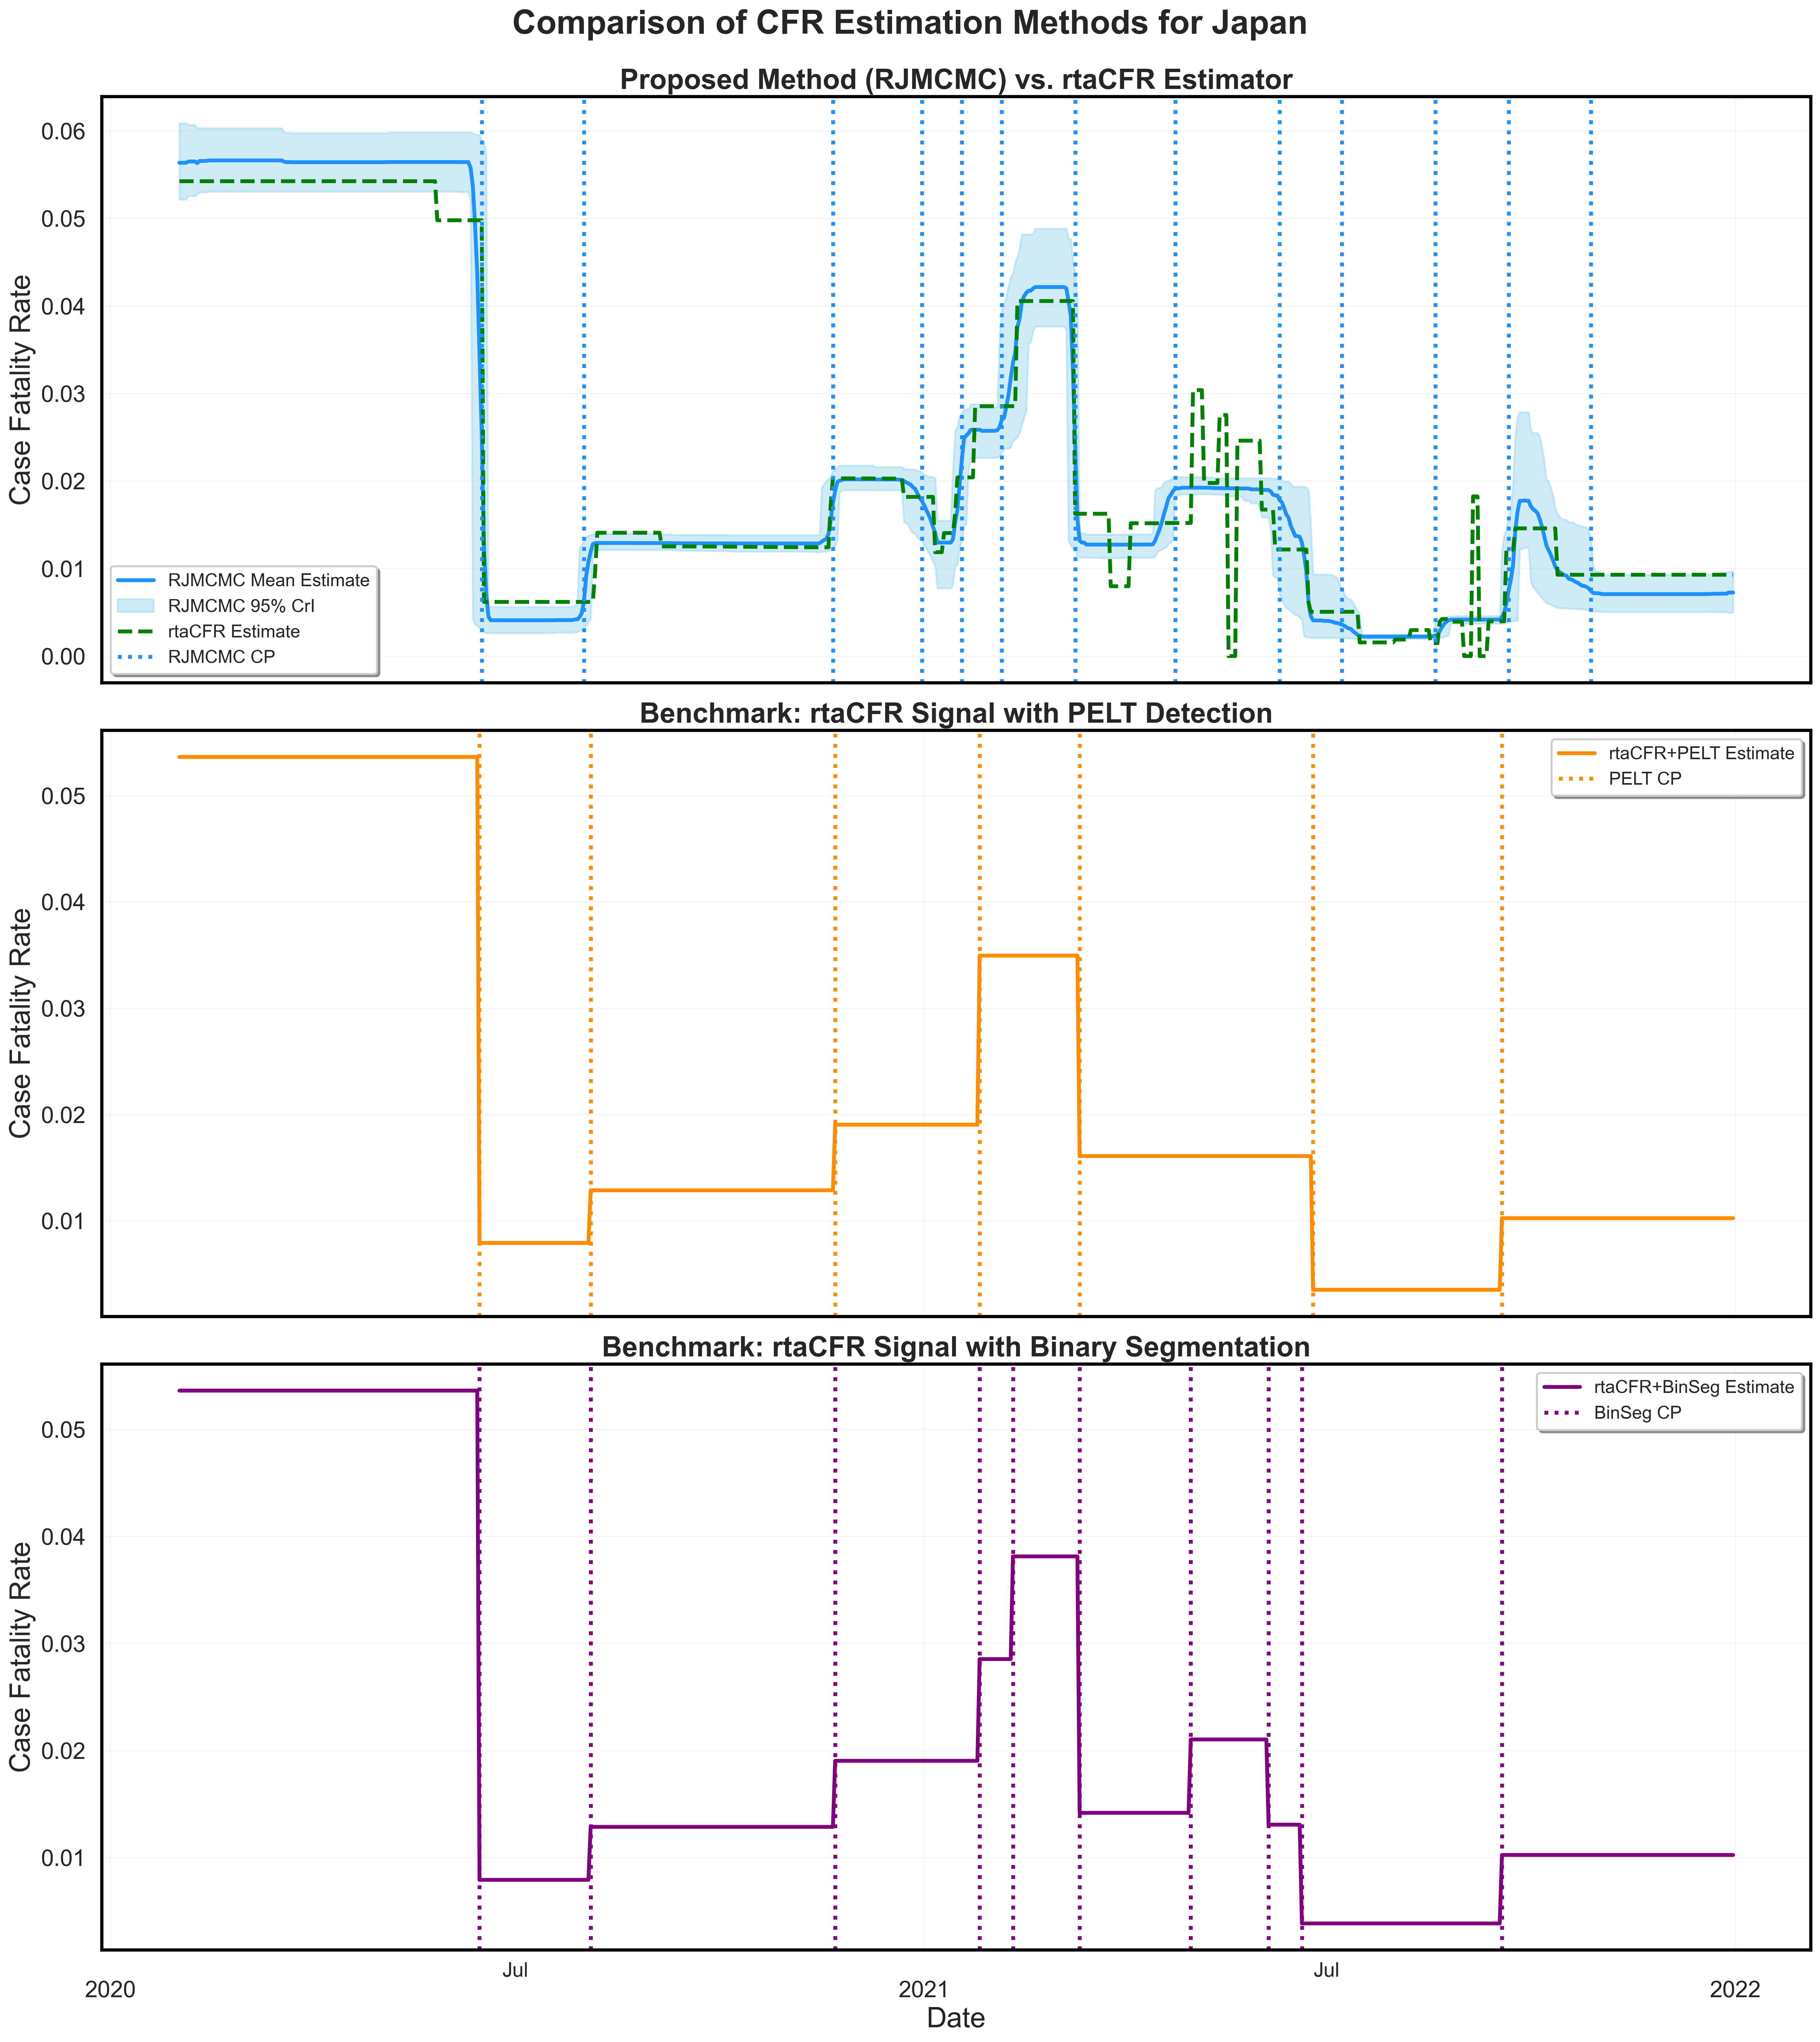

In [9]:
fig, axes = plt.subplots(3, 1, figsize=(20, 24), sharex=True)
fig.suptitle('Comparison of CFR Estimation Methods for Japan', fontsize=26, y=0.925, fontweight='bold')
time_axis = df['date']

# Helper function to create a clean legend
def clean_legend(ax):
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), fontsize=14, frameon=True, fancybox=True, shadow=True)

# Subplot 1: RJMCMC vs. rtaCFR
ax = axes[0]
p_t_mean = rjmcmc_results['p_t_hat']
p_t_lower = rjmcmc_results['p_t_lower_ci']
p_t_upper = rjmcmc_results['p_t_upper_ci']

ax.plot(time_axis, p_t_mean, color='dodgerblue', label='RJMCMC Mean Estimate', linewidth=3)
ax.fill_between(time_axis, p_t_lower, p_t_upper, color='skyblue', alpha=0.4, label='RJMCMC 95% CrI')
ax.plot(time_axis, rtacfr_signal, color='green', linestyle='--', lw=3, label='rtaCFR Estimate')

for i, cp_idx in enumerate(rjmcmc_results['taus_est']):
    label = 'RJMCMC CP' if i == 0 else ""
    ax.axvline(x=df['date'].iloc[cp_idx], color='dodgerblue', linestyle=':', lw=3, label=label)

ax.set_title('Proposed Method (RJMCMC) vs. rtaCFR Estimator', fontsize=22, fontweight='bold')
ax.set_ylabel('Case Fatality Rate', fontsize=22)
ax.tick_params(axis='both', labelsize=18)
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
# Set prominent black borders for all spines
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(2.5)
    spine.set_visible(True)
clean_legend(ax)

# Subplot 2: rtaCFR + PELT
ax = axes[1]
ax.plot(time_axis, pelt_results['p_t_hat'], color='darkorange', label='rtaCFR+PELT Estimate', linewidth=3)
for i, cp_idx in enumerate(pelt_results['taus_est']):
    label = 'PELT CP' if i == 0 else ""
    ax.axvline(x=df['date'].iloc[cp_idx], color='darkorange', linestyle=':', lw=3, label=label)

ax.set_title('Benchmark: rtaCFR Signal with PELT Detection', fontsize=22, fontweight='bold')
ax.set_ylabel('Case Fatality Rate', fontsize=22)
ax.tick_params(axis='both', labelsize=18)
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
# Set prominent black borders for all spines
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(2.5)
    spine.set_visible(True)
clean_legend(ax)

# Subplot 3: rtaCFR + BinSeg
ax = axes[2]
ax.plot(time_axis, binseg_results['p_t_hat'], color='purple', label='rtaCFR+BinSeg Estimate', linewidth=3)
for i, cp_idx in enumerate(binseg_results['taus_est']):
    label = 'BinSeg CP' if i == 0 else ""
    ax.axvline(x=df['date'].iloc[cp_idx], color='purple', linestyle=':', lw=3, label=label)

ax.set_title('Benchmark: rtaCFR Signal with Binary Segmentation', fontsize=22, fontweight='bold')
ax.set_ylabel('Case Fatality Rate', fontsize=22)
ax.set_xlabel('Date', fontsize=22)
ax.tick_params(axis='both', labelsize=18)
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
# Set prominent black borders for all spines
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(2.5)
    spine.set_visible(True)
clean_legend(ax)

# Format x-axis for dates
for ax in axes:
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[1, 7]))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))
    ax.tick_params(axis='x', which='major', pad=15, labelsize=18)
    ax.tick_params(axis='x', which='minor', labelsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.savefig(os.path.join(PLOTS_DIR, 'japan_cfr_comparison.pdf'), dpi=400, bbox_inches='tight')
plt.show()